## What do we *want* the CLASP case to match? 
Ideally, the CLASP approach of representing heterogeneity should come close to the mean of a case where you have a single atmospheric column over each land surface type. To replicate that situation, we run a series of SCAM simulations, prescribing just one surface type at a time. The mean of those simulations (area weighted to match the actual SGP gridcell) is somehwere near the "truth", or at least what we want to represent. <br><br>
<b>Date</b>: 22 March 2021

In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob
import Ngl
import Nio 
import metpy.calc as mpc
from metpy.units import units


## Read in data

In [2]:
#dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/SingleLandType/'
#fileStart = 'FSCAM.T42_T42.arm97.clasp_useAndre_noMomentsWithCTSMmods-64lev-irrig-srfFlxAvg_startDay0531.SrfMod-'

# Modification: z_const in CLUBB routine set to 32.5m, not 1. 
# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/SingleLandType/zconst_32p5/'
# fileStart = 'FSCAM.T42_T42.arm97.clasp_useAndre_useZconst32_noMomentsWithCTSMmods-64lev-irrig-srfFlxAvg_startDay0531.SrfMod-'
# sfcTypes = np.asarray(['BareGroundOnly','C3grassOnly','C4grassOnly', 'DeciduousTreeOnly', 'EvergreenTreeOnly',
#                        'HighDensityUrbanOnly', 'IrrigCropOnly', 'MedDensityUrbanOnly', 'RainCropOnly','LakeOnly'])


# Modification 2: z_const = 32.5m, and scm_iop_land_srf = .false.
dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/SingleLandType/zconst_32p5/V2_noSrfPropertiesPrescribed/'
fileStart = 'FSCAM.T42_T42.arm97.clasp_Andre_Zconst32_noMoments-64lev_startDay0531.SrfMod-'
sfcTypes = np.asarray(['BareGround','C3grass','C4grass', 'DeciduousTree', 'EvergreenTree',
                       'HighDensityUrban', 'IrrigCrop', 'MedDensityUrban', 'RainCrop','Lake'])

camEnd    = '.cam.h0.2015-05-31-00000.nc'
clmEnd    = '.clm2.h0.2015-05-31-00000.nc'



In [3]:
## Read everything into a single dataset (one for either CAM or CLM)
for iSfc in range(len(sfcTypes)):
    fileName_CAM = dataDir+fileStart+sfcTypes[iSfc]+camEnd
    fileName_CLM = dataDir+fileStart+sfcTypes[iSfc]+clmEnd

    # Add a "sfcType" dimension so that all 9 types can be read in
    with xr.open_dataset(fileName_CAM, decode_times=True) as camDS:
        camDS = camDS.expand_dims({"sfcType": 1})
    
    with xr.open_dataset(fileName_CLM, decode_times=True) as clmDS:
        clmDS = clmDS.expand_dims({"sfcType": 1})
    
    # Concatenate all those different surface type runs into a single xr dataset:
    if iSfc==0:
        camDS_full = camDS
        clmDS_full = clmDS
    else:
        camDS_full = xr.concat([camDS_full, camDS], "sfcType")
        clmDS_full = xr.concat([clmDS_full, clmDS], "sfcType")

# Fill out sfcType dimension with useful names 
camDS_full['sfcType'] = sfcTypes
clmDS_full['sfcType'] = sfcTypes

# Convert time index as a datetime_index
camDS_full['time']  = camDS_full.indexes['time'].to_datetimeindex()
clmDS_full['time']  = clmDS_full.indexes['time'].to_datetimeindex()


<ipython-input-3-9b8f2dedcbb3>:26: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_full['time']  = camDS_full.indexes['time'].to_datetimeindex()
<ipython-input-3-9b8f2dedcbb3>:27: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_full['time']  = clmDS_full.indexes['time'].to_datetimeindex()


In [4]:
## Limit analysis to throw away the first day (spin up) 
times      = pd.DatetimeIndex(camDS_full['time'].values,tz='UTC')
iTimeStart = np.where((times.day==1) & (times.hour==6))[0]

camDS_full = camDS_full.isel(time=np.arange(iTimeStart[0],len(times)))
clmDS_full = clmDS_full.isel(time=np.arange(iTimeStart[0],len(times)))

times      = times[iTimeStart[0]::] 


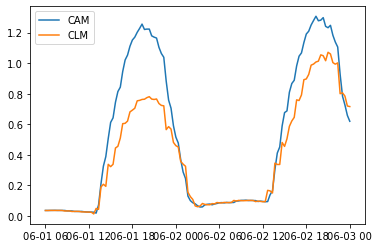

In [10]:
## Checking timing... 
plt.plot(times, np.squeeze(camDS_full['WP2_CLUBB'].values)[0,:,-1], label='CAM')
plt.plot(times, np.squeeze(clmDS_full['WP2_CLUBB'].values)[0,:], label='CLM')
plt.legend()


**Also need to know about the weights that should get applied to each patch.**<br><br>
Basing it off of log file from case where irrigation is active. Table created originally in "Create_NewSurfdata.ipynb", and saved out to an excel file "SGP_patchTypesAndWeights" that includes extra information on what each index actually means. <br><br>

In [5]:
## Read in weights for each patch
## -------------------------------

# Those were written out in this land log file (irrigation on): 
lndFile = '/Users/mdfowler/Documents/Analysis/CLASP/surfdata_modified/lnd.log.210315-162244'

with open(lndFile) as f:
    lines = f.readlines()
    
# Find place to end search of log file (use only one timestep): 
for iLines in range(len(lines)):
    if lines[iLines].startswith(' clm: completed timestep            0')==True:
        endLines = iLines
        
# Now loop through that selection of lines and get necessary variables 
selLines = lines[0:endLines]

patchWeights = []
patchTypes   = []
colTypes     = []
luTypes      = []

for iLines in range(len(selLines)):
    if selLines[iLines].startswith(' MDF: patch weight: ')==True:
        strArr = selLines[iLines].split(':')
        pWeight      = strArr[2].split('\n')
        patchWeights = np.append(patchWeights, float(pWeight[0]))
    
    if selLines[iLines].startswith(' MDF: patch type...')==True:
        strArr     = selLines[iLines].split('...')
        pType      = strArr[1].split('\n')
        patchTypes = np.append(patchTypes, int(pType[0]))
        
    if selLines[iLines].startswith(' MDF: col type...')==True:
        strArr     = selLines[iLines].split('...')
        cType      = strArr[1].split('\n')
        colTypes   = np.append(colTypes, int(cType[0]))
        
    if selLines[iLines].startswith(' MDF: landunit type...')==True:
        strArr     = selLines[iLines].split('...')
        lType      = strArr[1].split('\n')
        luTypes    = np.append(luTypes, int(lType[0]))


In [6]:
## Add a weights variable to xr datasets:
## ----------------------------------------

sfcTypeWeights = np.full([len(camDS_full.sfcType)], np.nan)

# Bare ground:
sfcTypeWeights[np.where(camDS_full.sfcType=='BareGround')[0]] = patchWeights[np.where( (colTypes==1) & (patchTypes==0))[0]]

# C3 grass:
sfcTypeWeights[np.where(camDS_full.sfcType=='C3grass')[0]]    = patchWeights[np.where( (colTypes==1) & (patchTypes==13))[0]]

# C4 grass: 
sfcTypeWeights[np.where(camDS_full.sfcType=='C4grass')[0]]    = patchWeights[np.where( (colTypes==1) & (patchTypes==14))[0]]

# Deciduous tree:
sfcTypeWeights[np.where(camDS_full.sfcType=='DeciduousTree')[0]] = patchWeights[np.where( (colTypes==1) & (patchTypes==7))[0]]

# Evergreen tree: 
sfcTypeWeights[np.where(camDS_full.sfcType=='EvergreenTree')[0]] = patchWeights[np.where( (colTypes==1) & (patchTypes==1))[0]]

# High density urban: 
sfcTypeWeights[np.where(camDS_full.sfcType=='HighDensityUrban')[0]] = np.sum(patchWeights[np.where( (luTypes==8) )[0]])

# Irrigated crop:
sfcTypeWeights[np.where(camDS_full.sfcType=='IrrigCrop')[0]] = patchWeights[np.where( (luTypes==2) & (patchTypes==16))[0]]

# Medium density urban: 
sfcTypeWeights[np.where(camDS_full.sfcType=='MedDensityUrban')[0]] = np.sum(patchWeights[np.where( (luTypes==9) )[0]])

# Rain-fed crop: 
sfcTypeWeights[np.where(camDS_full.sfcType=='RainCrop')[0]] = patchWeights[np.where( (luTypes==2) & (patchTypes==15))[0]]

# Lake point is made up, give zero weight for now: 
sfcTypeWeights[np.where(camDS_full.sfcType=='Lake')[0]] = 0.0



In [7]:
# After manually comparing to table in excel - this looks right! 
for iSfc in range(len(sfcTypes)):
    print( '%24s %18.4e %18.4f pct' % (camDS_full.sfcType.values[iSfc], sfcTypeWeights[iSfc], 
                                      (sfcTypeWeights[iSfc]/np.nansum(sfcTypeWeights))*100.0))
    

              BareGround         3.2374e-03             0.3237 pct
                 C3grass         2.5556e-01            25.5558 pct
                 C4grass         2.2167e-01            22.1671 pct
           DeciduousTree         6.5715e-03             0.6572 pct
           EvergreenTree         1.4638e-03             0.1464 pct
        HighDensityUrban         1.7698e-05             0.0018 pct
               IrrigCrop         2.2555e-02             2.2555 pct
         MedDensityUrban         1.5141e-03             0.1514 pct
                RainCrop         4.8741e-01            48.7411 pct
                    Lake         0.0000e+00             0.0000 pct


In [44]:
np.nansum(sfcTypeWeights)

1.0

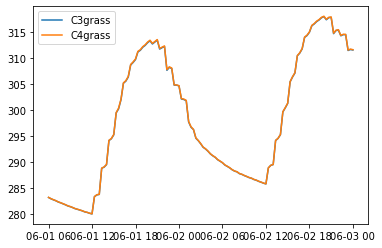

In [45]:
plt.plot(times,np.squeeze(camDS_full.TS.values[1,:,:,:]),label=camDS_full.sfcType.values[1])
plt.plot(times,np.squeeze(camDS_full.TS.values[2,:,:,:]),label=camDS_full.sfcType.values[2])
plt.legend()

Text(0.5, 1.0, 'Surface temperature (TS)')

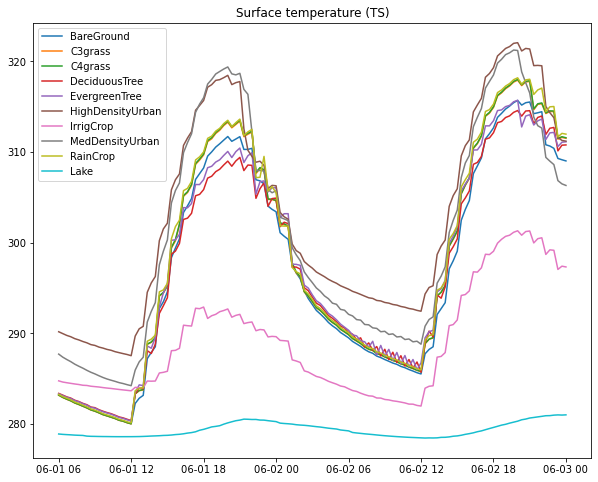

In [46]:
## How much does each patch vary? 
fig, ax1 = plt.subplots(1,1, figsize=(10, 8))

for iSfc in range(len(camDS_full.sfcType.values)):
    ax1.plot(times,np.squeeze(camDS_full.TS.values[iSfc,:,:,:]),label=camDS_full.sfcType.values[iSfc])
ax1.legend()
ax1.set_title('Surface temperature (TS)')


Text(0.5, 1.0, '(RHREFHT)')

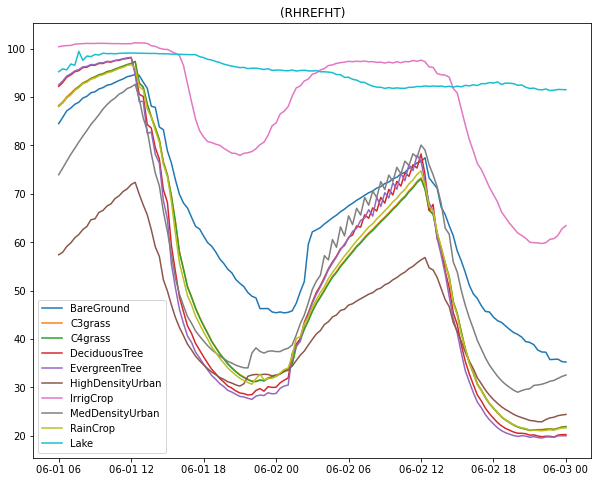

In [47]:
## How much does each patch vary? 
fig, ax1 = plt.subplots(1,1, figsize=(10, 8))

for iSfc in range(len(camDS_full.sfcType.values)):
    ax1.plot(times,np.squeeze(camDS_full.RHREFHT.values[iSfc,:,:,:]),label=camDS_full.sfcType.values[iSfc])
ax1.legend()
ax1.set_title('(RHREFHT)')


Text(0.5, 1.0, '(SHFLX)')

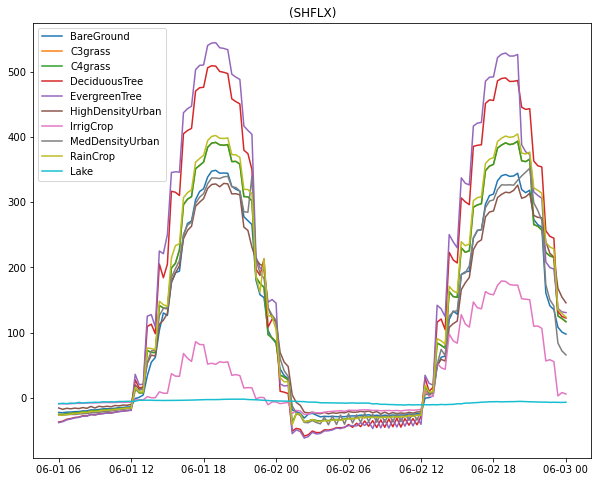

In [48]:
## How much does each patch vary? 
fig, ax1 = plt.subplots(1,1, figsize=(10, 8))

for iSfc in range(len(camDS_full.sfcType.values)):
    ax1.plot(times,np.squeeze(camDS_full.SHFLX.values[iSfc,:,:,:]),label=camDS_full.sfcType.values[iSfc])
ax1.legend()
ax1.set_title('(SHFLX)')

# ax1.set_xlim([datetime.date(2015,6,2,), datetime.date(2015,6,3)])
# ax1.set_ylim([0,20])

In [49]:
clmDS_full

<xarray.Dataset>
Dimensions:                        (cft: 2, glc_nec: 10, hist_interval: 2, lat: 1, levdcmp: 1, levgrnd: 25, levlak: 10, levsoi: 20, lon: 1, ltype: 9, natpft: 15, nvegwcs: 4, sfcType: 10, time: 127)
Coordinates:
  * levgrnd                        (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levlak                         (levlak) float32 0.05 0.6 2.1 ... 34.33 44.78
  * levdcmp                        (levdcmp) float32 1.0
  * time                           (time) datetime64[ns] 2015-06-01T06:00:00 ...
  * lon                            (lon) float32 261.6
  * lat                            (lat) float32 37.67
  * sfcType                        (sfcType) <U16 'BareGround' ... 'Lake'
Dimensions without coordinates: cft, glc_nec, hist_interval, levsoi, ltype, natpft, nvegwcs
Data variables:
    mcdate                         (sfcType, time) int32 20150601 ... 20150603
    mcsec                          (sfcType, time) int32 21600 22800 ... 85200 0
    mdcur                          (sfcType, time) int32 1 1 1 1 1 ... 2 2 2 2 3
    mscur                          (sfcType, time) int32 21600 22800 ... 85200 0
    nstep                          (sfcType, time) int32 90 91 92 ... 215 216
    time_bounds                    (sfcType, time, hist_interval) object 2015...
    date_written                   (sfcType, time) |S16 b'04/12/21' ... b'04/...
    time_written                   (sfcType, time) |S16 b'09:07:53' ... b'13:...
    area                           (sfcType, lat, lon) float32 7.68e+04 ... 7...
    landfrac                       (sfcType, lat, lon) float32 1.0 1.0 ... 1.0
    landmask                       (sfcType, lat, lon) float64 1.0 1.0 ... 1.0
    pftmask                        (sfcType, lat, lon) float64 1.0 1.0 ... 1.0
    nbedrock                       (sfcType, lat, lon) float64 20.0 ... 20.0
    ZSOI                           (sfcType, levgrnd, lat, lon) float32 0.01 ...
    DZSOI                          (sfcType, levgrnd, lat, lon) float32 0.02 ...
    WATSAT                         (sfcType, levgrnd, lat, lon) float32 0.550...
    SUCSAT                         (sfcType, levgrnd, lat, lon) float32 195.4...
    BSW                            (sfcType, levgrnd, lat, lon) float32 5.748...
    HKSAT                          (sfcType, levgrnd, lat, lon) float32 0.004...
    ZLAKE                          (sfcType, levlak, lat, lon) float32 nan .....
    DZLAKE                         (sfcType, levlak, lat, lon) float32 nan .....
    ATM_TOPO                       (sfcType, time, lat, lon) float32 0.0 ... 0.0
    BCDEP                          (sfcType, time, lat, lon) float32 1.688e-1...
    BTRAN2                         (sfcType, time, lat, lon) float32 nan ... nan
    BTRANMN                        (sfcType, time, lat, lon) float32 nan ... nan
    DSL                            (sfcType, time, lat, lon) float32 12.5 ......
    DSTDEP                         (sfcType, time, lat, lon) float32 2.67e-12...
    DSTFLXT                        (sfcType, time, lat, lon) float32 0.0 ... 0.0
    EFLXBUILD                      (sfcType, time, lat, lon) float32 0.0 ... 0.0
    EFLX_DYNBAL                    (sfcType, time, lat, lon) float32 0.0 ... 0.0
    EFLX_GRND_LAKE                 (sfcType, time, lat, lon) float32 nan ... ...
    EFLX_LH_TOT                    (sfcType, time, lat, lon) float32 -3.91 .....
    EFLX_LH_TOT_R                  (sfcType, time, lat, lon) float32 -3.91 .....
    ELAI                           (sfcType, time, lat, lon) float32 0.0 ... 0.0
    ERRH2O                         (sfcType, time, lat, lon) float32 -2.232e-...
    ERRH2OSNO                      (sfcType, time, lat, lon) float32 0.0 ... 0.0
    ERRSEB                         (sfcType, time, lat, lon) float32 -1.421e-...
    ERRSOI                         (sfcType, time, lat, lon) float32 -7.674e-...
    ERRSOL                         (sfcType, time, lat, lon) float32 0.0 ... ...
    ESAI                           (sfc

Text(0.5, 1.0, 'FSH_TO_COUPLER')

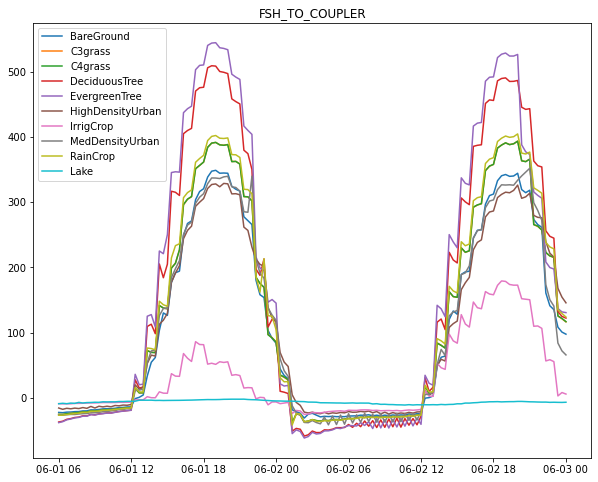

In [50]:
## How much does each patch vary? 
fig, ax1 = plt.subplots(1,1, figsize=(10, 8))

for iSfc in range(len(camDS_full.sfcType.values)):
    ax1.plot(times,np.squeeze(clmDS_full.FSH_TO_COUPLER.values[iSfc,:,:,:]),label=clmDS_full.sfcType.values[iSfc])
ax1.legend()
ax1.set_title('FSH_TO_COUPLER')


Text(0.5, 1.0, 'USTAR')

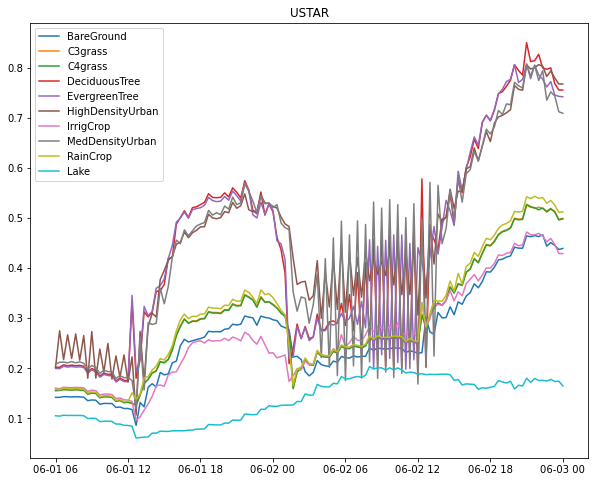

In [51]:
## How much does each patch vary? 
fig, ax1 = plt.subplots(1,1, figsize=(10, 8))

for iSfc in range(len(camDS_full.sfcType.values)):
    ax1.plot(times,np.squeeze(clmDS_full.USTAR.values[iSfc,:,:,:]),label=clmDS_full.sfcType.values[iSfc])
ax1.legend()
ax1.set_title('USTAR')



## Now get gridcell means (that account for heterogeneity too)

In [52]:
## First, just average using weights, don't worry about CLASP approach for incorporating heterogeneity 
## ----------------------------------------------------------------------------------------------------

#     The approach of ds.mean() doesn't quite work by default because some datatypes in camDS_full aren't 
#     capable of being averaged (i.e., strings and such). So I've created a subset of data that is likely of 
#     interest in camDS_keepVars. Just add any variables that are missing to that in the future.
 
camDS_keepVars = camDS_full[['SHFLX','LHFLX','PS','TREFHT','RHREFHT','PBLH','P0','hyam','hybm','hyai','hybi',
                             'CDNUMC','CLDBOT','CLDHGH','CLDICE','CLDLIQ','CLDLOW','CLDMED','CLDTOP','CLDTOT',
                             'CLOUD','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB','CONCLD','DTCOND','FLDS','FLNS','FLNT',
                              'FLUT','FSDS','FSNS','GCLDLWP','OMEGA','PRECC','PRECL','PRECSC','PRECSL','PRECT',
                              'PRECZ','Q','QFLX','RCMINLAYER_CLUBB','RCMTEND_CLUBB','RELHUM','RHO_CLUBB',
                              'RIMTEND_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','SWCF',
                              'T','TAUX','TAUY','TGCLDCWP','TGCLDIWP','TGCLDLWP','THETAL','THLP2_CLUBB','TMQ',
                              'TS','U10','U','V','UP2_CLUBB','UPWP_CLUBB','UTEND_CLUBB','USTAR','VP2_CLUBB',
                              'VPWP_CLUBB','VTEND_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WP2_CLUBB','WP3_CLUBB',
                              'WP4_CLUBB','WPRCP_CLUBB','WPRTP2_CLUBB','WPRTPTHLP_CLUBB','WPRTP_CLUBB',
                              'WPTHLP2_CLUBB','WPTHLP_CLUBB','Z3']]

camDS_fullWeighted = camDS_keepVars.weighted(xr.DataArray(sfcTypeWeights, dims={"sfcType": sfcTypes}))
camDS_fullWeighted = camDS_fullWeighted.mean(dim="sfcType")

# Do the same for CLM dataset...
clmDS_keepVars = clmDS_full[['DSL','EFLX_LH_TOT','FCEV','FCOV','FCTR','FGEV','FGR','FIRA','FIRE','FLDS','FSDS',
                             'FSR','H2OCAN','H2OSFC','H2OSOI','PBOT','PCT_CFT','PCT_LANDUNIT','PCT_NAT_PFT',
                             'QBOT','Q2M','QCHARGE','QDRAI','QINFL','QINTR','QOVER','QP2_CLUBB','QRUNOFF',
                             'QSOIL','QVEGE','QVEGT','RAIN','SOILLIQ','SOILWATER_10CM','TAUX','TAUY','TBOT',
                             'THLP2_CLUBB','THLPQP_CLUBB','TSA','UP2_CLUBB','USTAR','WP2QP_CLUBB','WP2THLP_CLUBB',
                             'WP2_CLUBB','WP3_CLUBB','WP4_CLUBB','WPQP2_CLUBB','WPQP_CLUBB','WPTHLP2_CLUBB',
                             'WPTHLPQP_CLUBB','WPTHLP_CLUBB','ZBOT','ZETA']]

clmDS_fullWeighted = clmDS_keepVars.weighted(xr.DataArray(sfcTypeWeights, dims={"sfcType": sfcTypes}))
clmDS_fullWeighted = clmDS_fullWeighted.mean(dim="sfcType")


**Also want everything on consistent pressure levels** <br><br>
There's inevitable mismatches between certain CLUBB fields (which are often computed on the layer interfaces) and other variables of interest like thetal (computed for layer midpoints). So one solution might be to just interpolate **every variable we care about** to a single, consistent vertical frame of reference. <br>

Note: Ngl.vinth2p doesn't actually accept xr datasets; it works on numpy arrays. So this function below can help you still work with just xr datasets, but handles the conversion to/from np.

In [53]:
''' 
Short function to wrap around Ngl.vinth2p and return things in useful xr.dataset format. 
'''
def interpolate_DSvar(DS,varName,pnew,pftFlag): 
    
    #Case where we don't have individual PFTs:
    if pftFlag==0:

        varOrig = np.asarray(DS[varName].values)
        p0mb    = np.asarray(DS.P0.values)/100        # mb
        PS      = np.asarray(DS.PS.values)               # Pa 

        # Assuming by DEFAULT here that lev = 64 levels, ilev = 65 levels. 
        #    AND that data is ordered [time,lev]
        nlevs = np.shape(varOrig)[1]

        # Pull out hya/hyb profiles
        if nlevs==64: 
            hya = np.asarray(DS.hyam.values[:])
            hyb = np.asarray(DS.hybm.values[:])
        elif nlevs==65:
            hya = np.asarray(DS.hyai.values[:])
            hyb = np.asarray(DS.hybi.values[:])
        else: 
            print('!! Unrecognized number of levels !!')

        varInterp = Ngl.vinth2p(varOrig,hya,hyb,pnew,PS,1,p0mb,1,True)

        # Save interpolated values back into DS
        #interpDS = dFull['Plcl']  = (('time','lat','lon'), Plcl_sel)
        varInterpDS = xr.DataArray( data=np.squeeze(varInterp), 
                                    dims=["time","interpLevs"],
                                    coords=dict(time = (["time"], DS.time.values),
                                                interpLevs = (["interpLevs"], pnew)),
                              )

    elif pftFlag==1:
        varOrig_all = np.asarray(DS[varName].values)
        p0mb        = np.asarray(DS.P0.values)[0]/100        # mb
        
        nPFTs = np.shape(varOrig_all)[0]
        nlevs = np.shape(varOrig_all)[2]
        
        # Pull out hya/hyb profiles
        if nlevs==64: 
            hya = np.asarray(DS.hyam.values[0,:])
            hyb = np.asarray(DS.hybm.values[0,:])
        elif nlevs==65:
            hya = np.asarray(DS.hyai.values[0,:])
            hyb = np.asarray(DS.hybi.values[0,:])
        else: 
            print('!! Unrecognized number of levels !!')
        
        varInterp = np.full([nPFTs,np.shape(varOrig_all)[1],len(pnew)], np.nan)   #[PFT, time, lev]
        
        for iPft in range(nPFTs):
            varOrig = varOrig_all[iPft,:,:,:,:]
            PS      = np.asarray(DS.PS.values[iPft,:,:,:])

            varInterp[iPft,:,:] = np.squeeze(Ngl.vinth2p(varOrig,hya,hyb,pnew,PS,1,p0mb,1,True))
        
        
        varInterpDS = xr.DataArray( data=np.squeeze(varInterp), 
                                    dims=["sfcType","time","interpLevs"],
                                    coords=dict(sfcType = (["sfcType"],DS.sfcType.values),
                                                time = (["time"], DS.time.values),
                                                interpLevs = (["interpLevs"], pnew)),
                              )
        
    DS[varName+'_interp'] = varInterpDS
    
    return DS


In [54]:
# Interpolate to consistent pressure levels: 
pnew64 = np.arange(700.0,990.0,10.0) 


In [55]:
## Handle interpolation for grid mean values:
## ------------------------------------------

# Array of variable names to be interpolated...
varNames = np.asarray(['THETAL','Q','THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','UP2_CLUBB','WP2_CLUBB',
                       'WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','T','OMEGA','RVMTEND_CLUBB',
                       'STEND_CLUBB','CLDLIQ','CLOUD'])

for iVar in range(len(varNames)):
    if iVar==0:
        newDS_fullWgt = interpolate_DSvar(camDS_fullWeighted,varNames[iVar],pnew64,0)
    else:
        newDS_fullWgt = interpolate_DSvar(newDS_fullWgt,varNames[iVar],pnew64,0)


In [56]:
## Handle interpolation for individual PFT values:
## ------------------------------------------

# Array of variable names to be interpolated...
varNames = np.asarray(['THETAL','Q'])

for iVar in range(len(varNames)):
    if iVar==0:
        newDS_keepVars = interpolate_DSvar(camDS_keepVars,varNames[iVar],pnew64,1)        
    else:
        newDS_keepVars = interpolate_DSvar(newDS_keepVars,varNames[iVar],pnew64,1)        


**Now that everything's on the same vertical levels**, we can go ahead and figure out how to account for heterogeneity. Following the equations from what we're doing in CLASP (e.g., how to combine PDFs):

$$ \theta^{'2} = \theta^{'2}_{gm} + \sum f_i*((\theta_i - \theta_{gm})^2) $$
<br>
$$ q^{'2} = q^{'2}_{gm} + \sum f_i*((q_i - q_{gm})^2) $$
<br>
$$\theta' q' = \theta'q'_{gm} + \sum f_i*((\theta_i - \theta_{gm})*(q_i - q_{gm})) $$



In [57]:
## Now add in that heterogeneous term to each of the moments we care about...
## --------------------------------------------------------------------------

patchThetaDiff = np.full([len(sfcTypes), len(newDS_keepVars.time.values), len(newDS_keepVars.interpLevs.values)], np.nan)
patchQdiff     = np.full([len(sfcTypes), len(newDS_keepVars.time.values), len(newDS_keepVars.interpLevs.values)], np.nan)

for iSfc in range(len(sfcTypes)):
    patchThetaDiff[iSfc,:,:] =  np.squeeze(newDS_keepVars.THETAL_interp.values)[iSfc,:,:] - np.squeeze(newDS_fullWgt.THETAL_interp.values)[:,:]
    patchQdiff[iSfc,:,:]     =  np.squeeze(newDS_keepVars.Q_interp.values)[iSfc,:,:]      - np.squeeze(newDS_fullWgt.Q_interp.values)[:,:]

# Define empty arrays for HTG versions of moments 
thlp2_withHTG   = np.full([len(newDS_keepVars.time.values), len(newDS_keepVars.interpLevs.values)], np.nan)
rtp2_withHTG    = np.full([len(newDS_keepVars.time.values), len(newDS_keepVars.interpLevs.values)], np.nan)
thlpRtp_withHTG = np.full([len(newDS_keepVars.time.values), len(newDS_keepVars.interpLevs.values)], np.nan)

for iTime in range(len(newDS_keepVars.time.values)):
    for iLev in range(len(newDS_keepVars.interpLevs.values)):
        patchThetaDiffSqr_wgt = sfcTypeWeights * (patchThetaDiff[:,iTime,iLev]**2.0)
        patchRtDiffSqr_wgt    = sfcTypeWeights * (patchQdiff[:,iTime,iLev]**2.0)
        patchThlRt_wgt        = sfcTypeWeights * (patchThetaDiff[:,iTime,iLev]*patchQdiff[:,iTime,iLev])
        
        thlp2_withHTG[iTime,iLev]   = np.squeeze(newDS_fullWgt.THLP2_CLUBB_interp.values)[iTime,iLev]   + (np.nansum(patchThetaDiffSqr_wgt)/np.nansum(sfcTypeWeights))
        rtp2_withHTG[iTime,iLev]    = np.squeeze(newDS_fullWgt.RTP2_CLUBB_interp.values)[iTime,iLev]    + (np.nansum(patchRtDiffSqr_wgt)/np.nansum(sfcTypeWeights))
        thlpRtp_withHTG[iTime,iLev] = np.squeeze(newDS_fullWgt.RTPTHLP_CLUBB_interp.values)[iTime,iLev] + (np.nansum(patchThlRt_wgt)/np.nansum(sfcTypeWeights))
        

## Compare to CLASP case (heterogeneity computed on land side, but just 1 atm column)


In [58]:
dataDir = '~/Documents/Analysis/CLASP/SCAM_runs/NoMoments-SrfFluxAvg-useAndre-scmIOPlandSrfOff-zconst32p5/'

camFilename_HTG = 'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1-64lev_startDay0531_ctsmHTG.cam.h0.2015-05-31-00172.nc'
clmFilename_HTG = 'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1-64lev_startDay0531_ctsmHTG.clm2.h0.2015-05-31-00172.nc'

camFilename_HMG = 'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1_noMoments-64lev_startDay0531_ctsmHMG.cam.h0.2015-05-31-00000.nc'
clmFilename_HMG = 'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1_noMoments-64lev_startDay0531_ctsmHMG.clm2.h0.2015-05-31-00000.nc'

# --- HTG case ----
with xr.open_dataset(dataDir+camFilename_HTG, decode_times='True') as camDS_claspHTG:
    camDS_claspHTG['time']  = camDS_claspHTG.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(camDS_claspHTG['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    camDS_claspHTG = camDS_claspHTG.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))
    

with xr.open_dataset(dataDir+clmFilename_HTG, decode_times='True') as clmDS_claspHTG: 
    clmDS_claspHTG['time']  = clmDS_claspHTG.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(clmDS_claspHTG['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    clmDS_claspHTG = clmDS_claspHTG.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))


# --- HMG case ----
with xr.open_dataset(dataDir+camFilename_HMG, decode_times='True') as camDS_claspHMG:
    camDS_claspHMG['time']  = camDS_claspHMG.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(camDS_claspHMG['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    camDS_claspHMG = camDS_claspHMG.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))
    

with xr.open_dataset(dataDir+clmFilename_HMG, decode_times='True') as clmDS_claspHMG: 
    clmDS_claspHMG['time']  = clmDS_claspHMG.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(clmDS_claspHMG['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    clmDS_claspHMG = clmDS_claspHMG.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))


timesHTG = pd.DatetimeIndex(clmDS_claspHTG['time'].values)    


<ipython-input-58-fa9a449f8586>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_claspHTG['time']  = camDS_claspHTG.indexes['time'].to_datetimeindex()
<ipython-input-58-fa9a449f8586>:19: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_claspHTG['time']  = clmDS_claspHTG.indexes['time'].to_datetimeindex()
<ipython-input-58-fa9a449f8586>:28: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that dep

In [59]:
# Interpolate to consistent pressure levels: 
pnew64 = np.arange(700.0,990.0,10.0) 

# Array of variable names to be interpolated...

varNames = np.asarray(['THETAL','Q','THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','UP2_CLUBB','WP2_CLUBB',
                       'WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','T','OMEGA','RVMTEND_CLUBB',
                       'STEND_CLUBB','CLDLIQ','CLOUD'])

for iVar in range(len(varNames)):
    if iVar==0:
        newDS_CLASP_HMG = interpolate_DSvar(camDS_claspHMG,varNames[iVar],pnew64,0)
        newDS_CLASP_HTG = interpolate_DSvar(camDS_claspHTG,varNames[iVar],pnew64,0)
    else:
        newDS_CLASP_HMG = interpolate_DSvar(newDS_CLASP_HMG,varNames[iVar],pnew64,0)
        newDS_CLASP_HTG = interpolate_DSvar(newDS_CLASP_HTG,varNames[iVar],pnew64,0)
        

## Plot a comparison

Text(0.5, 0, 'Time (UTC: mm/dd hh)')

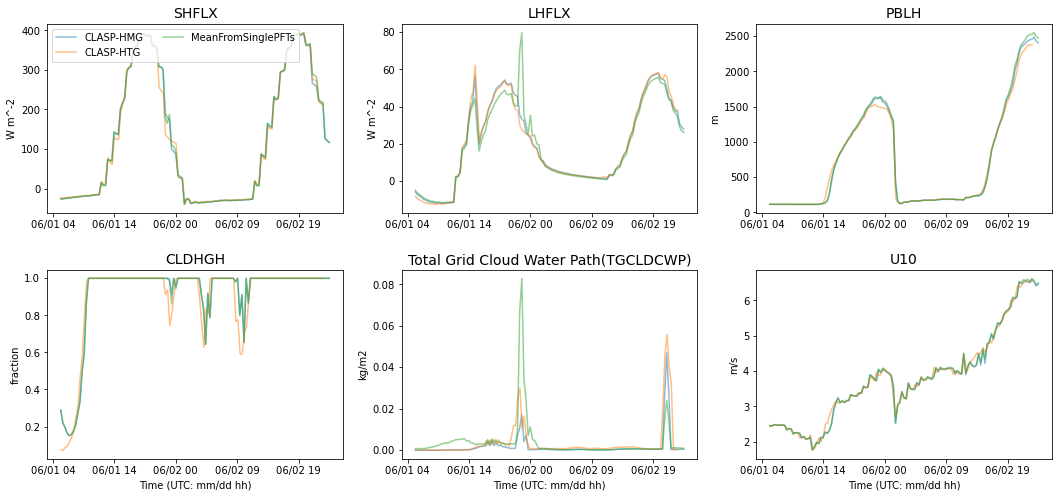

In [60]:
# Format for time on x-axis
myFmt = mdates.DateFormatter('%m/%d %H')

fig, axs = plt.subplots(2,3, figsize=(18, 8))
axs      = axs.ravel()
fig.subplots_adjust(hspace=0.3)

axs[0].plot(times, np.squeeze(camDS_claspHMG.SHFLX.values),alpha=0.5,label='CLASP-HMG')
axs[0].plot(timesHTG, np.squeeze(camDS_claspHTG.SHFLX.values),alpha=0.5,label='CLASP-HTG')
axs[0].plot(times, np.squeeze(camDS_fullWeighted.SHFLX.values),alpha=0.5,label='MeanFromSinglePFTs')
axs[0].legend(ncol=2,loc='upper left')
axs[0].set_title('SHFLX',fontsize=14)
axs[0].set_ylabel('W m^-2')
# axs[0].set_ylim([-50,275])
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[1].plot(times, np.squeeze(camDS_claspHMG.LHFLX.values),alpha=0.5,label='CLASP-HMG')
axs[1].plot(timesHTG, np.squeeze(camDS_claspHTG.LHFLX.values),alpha=0.5,label='CLASP-HTG')
axs[1].plot(times, np.squeeze(camDS_fullWeighted.LHFLX.values),alpha=0.5,label='MeanFromSinglePFTs')
axs[1].set_title('LHFLX',fontsize=14)
axs[1].set_ylabel('W m^-2')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[2].plot(times, np.squeeze(camDS_claspHMG.PBLH.values),alpha=0.5,label='CLASP-HMG')
axs[2].plot(timesHTG, np.squeeze(camDS_claspHTG.PBLH.values),alpha=0.5,label='CLASP-HTG')
axs[2].plot(times, np.squeeze(camDS_fullWeighted.PBLH.values),alpha=0.5,label='MeanFromSinglePFTs')
axs[2].set_title('PBLH',fontsize=14)
axs[2].set_ylabel('m')
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[3].plot(times, np.squeeze(camDS_claspHMG.CLDHGH.values),alpha=0.5,label='CLASP-HMG')
axs[3].plot(timesHTG, np.squeeze(camDS_claspHTG.CLDHGH.values),alpha=0.5,label='CLASP-HTG')
axs[3].plot(times, np.squeeze(camDS_fullWeighted.CLDHGH.values),alpha=0.5,label='MeanFromSinglePFTs')
axs[3].set_title('CLDHGH',fontsize=14)
axs[3].set_ylabel('fraction')
axs[3].xaxis.set_major_formatter(myFmt)
axs[3].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[3].set_xlabel('Time (UTC: mm/dd hh)')
#axs[3].set_ylim([0.5,1.1])

axs[4].plot(times, np.squeeze(camDS_claspHMG.TGCLDCWP.values),alpha=0.5,label='CLASP-HMG')
axs[4].plot(timesHTG, np.squeeze(camDS_claspHTG.TGCLDCWP.values),alpha=0.5,label='CLASP-HTG')
axs[4].plot(times, np.squeeze(camDS_fullWeighted.TGCLDCWP.values),alpha=0.5,label='MeanFromSinglePFTs')
axs[4].set_title('Total Grid Cloud Water Path(TGCLDCWP)',fontsize=14)
axs[4].set_ylabel('kg/m2')
axs[4].xaxis.set_major_formatter(myFmt)
axs[4].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[4].set_xlabel('Time (UTC: mm/dd hh)')

axs[5].plot(times, np.squeeze(camDS_claspHMG.U10.values),alpha=0.5,label='CLASP-HMG')
axs[5].plot(timesHTG, np.squeeze(camDS_claspHTG.U10.values),alpha=0.5,label='CLASP-HTG')
axs[5].plot(times, np.squeeze(camDS_fullWeighted.U10.values),alpha=0.5,label='MeanFromSinglePFTs')
axs[5].set_title('U10',fontsize=14)
axs[5].set_ylabel('m/s')
axs[5].xaxis.set_major_formatter(myFmt)
axs[5].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[5].set_xlabel('Time (UTC: mm/dd hh)')



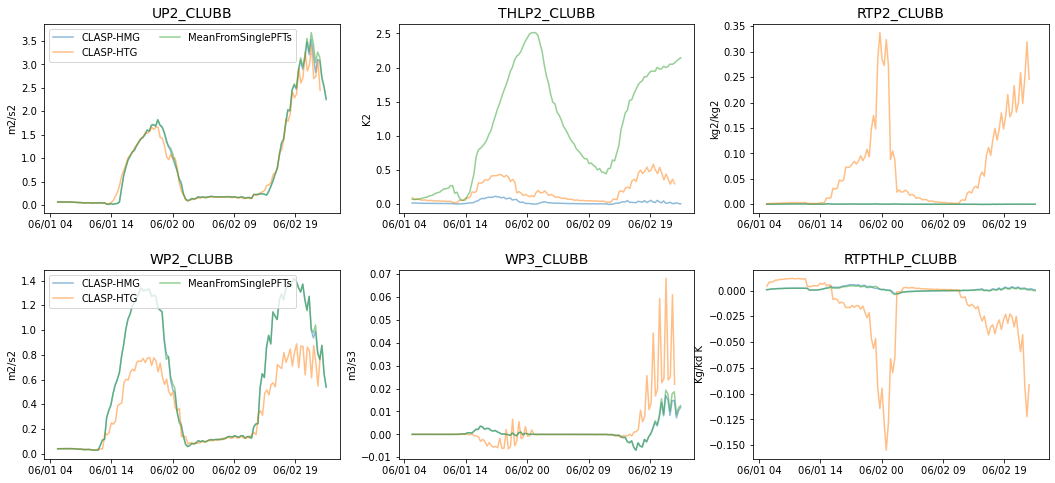

In [24]:
# Format for time on x-axis
myFmt = mdates.DateFormatter('%m/%d %H')

fig, axs = plt.subplots(2,3, figsize=(18, 8))
axs      = axs.ravel()
fig.subplots_adjust(hspace=0.3)

axs[0].plot(times, np.squeeze(newDS_CLASP_HMG.UP2_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HMG')
axs[0].plot(timesHTG, np.squeeze(newDS_CLASP_HTG.UP2_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HTG')
axs[0].plot(times, np.squeeze(newDS_fullWgt.UP2_CLUBB_interp.values)[:,-1],alpha=0.5,label='MeanFromSinglePFTs')
axs[0].legend(ncol=2,loc='upper left')
axs[0].set_title('UP2_CLUBB',fontsize=14)
axs[0].set_ylabel('m2/s2')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[1].plot(times, np.squeeze(newDS_CLASP_HMG.THLP2_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HMG')
axs[1].plot(timesHTG, np.squeeze(newDS_CLASP_HTG.THLP2_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HTG')
axs[1].plot(times, np.squeeze(thlp2_withHTG)[:,-1],alpha=0.5,label='MeanFromSinglePFTs')
axs[1].set_title('THLP2_CLUBB',fontsize=14)
axs[1].set_ylabel('K2')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[2].plot(times, np.squeeze(newDS_CLASP_HMG.RTP2_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HMG')
axs[2].plot(timesHTG, np.squeeze(newDS_CLASP_HTG.RTP2_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HTG')
axs[2].plot(times, np.squeeze(rtp2_withHTG)[:,-1],alpha=0.5,label='MeanFromSinglePFTs')
axs[2].set_title('RTP2_CLUBB',fontsize=14)
axs[2].set_ylabel('kg2/kg2')
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[3].plot(times, np.squeeze(newDS_CLASP_HMG.WP2_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HMG')
axs[3].plot(timesHTG, np.squeeze(newDS_CLASP_HTG.WP2_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HTG')
axs[3].plot(times, np.squeeze(newDS_fullWgt.WP2_CLUBB_interp.values)[:,-1],alpha=0.5,label='MeanFromSinglePFTs')
axs[3].legend(ncol=2,loc='upper left')
axs[3].set_title('WP2_CLUBB',fontsize=14)
axs[3].set_ylabel('m2/s2')
axs[3].xaxis.set_major_formatter(myFmt)
axs[3].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[4].plot(times, np.squeeze(newDS_CLASP_HMG.WP3_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HMG')
axs[4].plot(timesHTG, np.squeeze(newDS_CLASP_HTG.WP3_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HTG')
axs[4].plot(times, np.squeeze(newDS_fullWgt.WP3_CLUBB_interp.values)[:,-1],alpha=0.5,label='MeanFromSinglePFTs')
axs[4].set_title('WP3_CLUBB',fontsize=14)
axs[4].set_ylabel('m3/s3')
axs[4].xaxis.set_major_formatter(myFmt)
axs[4].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[5].plot(times, np.squeeze(newDS_CLASP_HMG.RTPTHLP_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HMG')
axs[5].plot(timesHTG, np.squeeze(newDS_CLASP_HTG.RTPTHLP_CLUBB_interp.values)[:,-1],alpha=0.5,label='CLASP-HTG')
axs[5].plot(times, np.squeeze(thlpRtp_withHTG)[:,-1],alpha=0.5,label='MeanFromSinglePFTs')
axs[5].set_title('RTPTHLP_CLUBB',fontsize=14)
axs[5].set_ylabel('Kg/kd K')
axs[5].xaxis.set_major_formatter(myFmt)
axs[5].xaxis.set_major_locator(plt.MaxNLocator(5))


### Compare vertical profiles?

In [26]:
# Now convert those to Central time 
times_local = times.tz_convert(tz='US/Central') 


Text(0.5, 1.0, '8-10a Mean \nTemperature Variance')

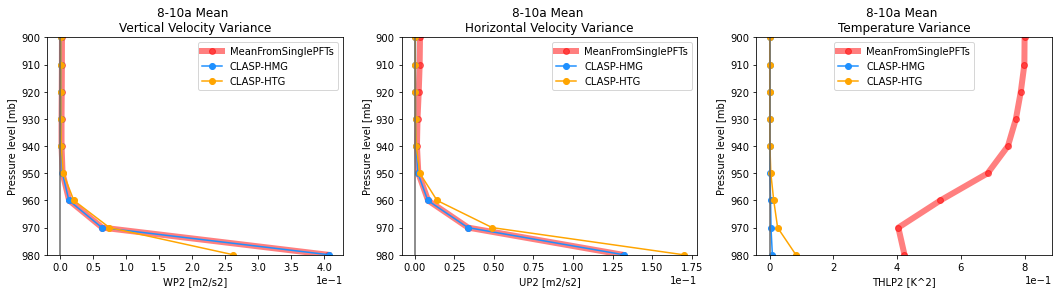

In [51]:
# Plot mean vertical profiles in morning? (8-10a local)
iMorning     = np.where((times_local.hour>=8) & (times_local.hour<10))[0]

fig, axs_all = plt.subplots(1,3, figsize=(18, 4),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

axs[0].plot(np.nanmean(np.squeeze(newDS_fullWgt.WP2_CLUBB_interp.values)[iMorning,:], axis=0), pnew64,'o-',color='r',linewidth=6,alpha=0.5,label='MeanFromSinglePFTs')
axs[0].plot(np.nanmean(np.squeeze(newDS_CLASP_HMG.WP2_CLUBB_interp.values)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-HMG')
axs[0].plot(np.nanmean(np.squeeze(newDS_CLASP_HTG.WP2_CLUBB_interp.values)[iMorning,:], axis=0), pnew64,'o-',color='orange',label='CLASP-HTG')
axs[0].axvline(0,color='dimgrey')
axs[0].set_ylim([900,980])
axs[0].invert_yaxis()
axs[0].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[0].set_ylabel('Pressure level [mb]')
axs[0].set_xlabel('WP2 [m2/s2]')
axs[0].set_title('8-10a Mean \nVertical Velocity Variance')


axs[1].plot(np.nanmean(np.squeeze(newDS_fullWgt.UP2_CLUBB_interp.values)[iMorning,:], axis=0), pnew64,'o-',color='r',linewidth=6,alpha=0.5,label='MeanFromSinglePFTs')
axs[1].plot(np.nanmean(np.squeeze(newDS_CLASP_HMG.UP2_CLUBB_interp.values)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-HMG')
axs[1].plot(np.nanmean(np.squeeze(newDS_CLASP_HTG.UP2_CLUBB_interp.values)[iMorning,:], axis=0), pnew64,'o-',color='orange',label='CLASP-HTG')
axs[1].axvline(0,color='dimgrey')
axs[1].set_ylim([900,980])
axs[1].invert_yaxis()
axs[1].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[1].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[1].set_ylabel('Pressure level [mb]')
axs[1].set_xlabel('UP2 [m2/s2]')
axs[1].set_title('8-10a Mean \nHorizontal Velocity Variance')

# axs[2].plot(np.nanmean(np.squeeze(newDS_fullWgt.THLP2_CLUBB_interp.values)[iMorning,:], axis=0), pnew64,'o-',color='r',label='MeanFromSinglePFTs')
axs[2].plot(np.nanmean(np.squeeze(thlp2_withHTG)[iMorning,:], axis=0), pnew64,'o-',color='r',linewidth=6,alpha=0.5,label='MeanFromSinglePFTs')
axs[2].plot(np.nanmean(np.squeeze(newDS_CLASP_HMG.THLP2_CLUBB_interp.values)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-HMG')
axs[2].plot(np.nanmean(np.squeeze(newDS_CLASP_HTG.THLP2_CLUBB_interp.values)[iMorning,:], axis=0), pnew64,'o-',color='orange',label='CLASP-HTG')
axs[2].axvline(0,color='dimgrey')
axs[2].set_ylim([900,980])
axs[2].invert_yaxis()
axs[2].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[2].set_ylabel('Pressure level [mb]')
axs[2].set_xlabel('THLP2 [K^2]')
axs[2].set_title('8-10a Mean \nTemperature Variance')



Text(0.5, 1.0, '2-5p Mean \nTemperature Variance')

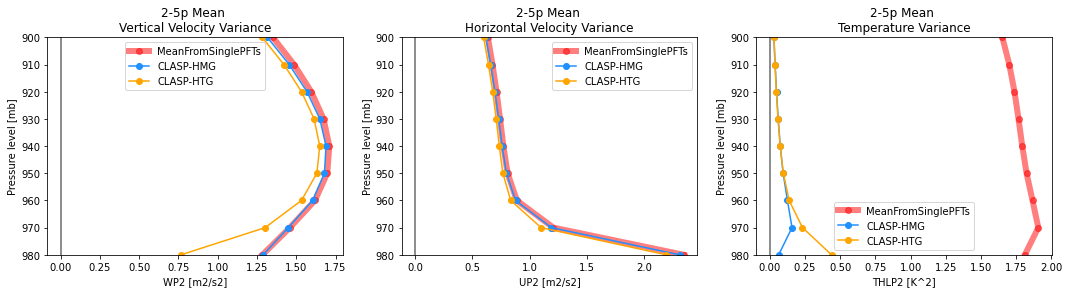

In [52]:
# Plot mean vertical profiles in afternoon? (2-5p local)
iAfternoon  = np.where((times_local.hour>=14) & (times_local.hour<17))[0]

fig, axs_all = plt.subplots(1,3, figsize=(18, 4),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

axs[0].plot(np.nanmean(np.squeeze(newDS_fullWgt.WP2_CLUBB_interp.values)[iAfternoon,:], axis=0), pnew64,'o-',color='r',linewidth=6,alpha=0.5,label='MeanFromSinglePFTs')
axs[0].plot(np.nanmean(np.squeeze(newDS_CLASP_HMG.WP2_CLUBB_interp.values)[iAfternoon,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-HMG')
axs[0].plot(np.nanmean(np.squeeze(newDS_CLASP_HTG.WP2_CLUBB_interp.values)[iAfternoon,:], axis=0), pnew64,'o-',color='orange',label='CLASP-HTG')
axs[0].axvline(0,color='dimgrey')
axs[0].set_ylim([900,980])
axs[0].invert_yaxis()
axs[0].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[0].set_ylabel('Pressure level [mb]')
axs[0].set_xlabel('WP2 [m2/s2]')
axs[0].set_title('2-5p Mean \nVertical Velocity Variance')


axs[1].plot(np.nanmean(np.squeeze(newDS_fullWgt.UP2_CLUBB_interp.values)[iAfternoon,:], axis=0), pnew64,'o-',color='r',linewidth=6,alpha=0.5,label='MeanFromSinglePFTs')
axs[1].plot(np.nanmean(np.squeeze(newDS_CLASP_HMG.UP2_CLUBB_interp.values)[iAfternoon,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-HMG')
axs[1].plot(np.nanmean(np.squeeze(newDS_CLASP_HTG.UP2_CLUBB_interp.values)[iAfternoon,:], axis=0), pnew64,'o-',color='orange',label='CLASP-HTG')
axs[1].axvline(0,color='dimgrey')
axs[1].set_ylim([900,980])
axs[1].invert_yaxis()
axs[1].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[1].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[1].set_ylabel('Pressure level [mb]')
axs[1].set_xlabel('UP2 [m2/s2]')
axs[1].set_title('2-5p Mean \nHorizontal Velocity Variance')

axs[2].plot(np.nanmean(np.squeeze(thlp2_withHTG)[iAfternoon,:], axis=0), pnew64,'o-',color='r',linewidth=6,alpha=0.5,label='MeanFromSinglePFTs')
# axs[2].plot(np.nanmean(np.squeeze(newDS_fullWgt.THLP2_CLUBB_interp.values)[iAfternoon,:], axis=0), pnew64,'o-',color='r',label='MeanFromSinglePFTs')
axs[2].plot(np.nanmean(np.squeeze(newDS_CLASP_HMG.THLP2_CLUBB_interp.values)[iAfternoon,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-HMG')
axs[2].plot(np.nanmean(np.squeeze(newDS_CLASP_HTG.THLP2_CLUBB_interp.values)[iAfternoon,:], axis=0), pnew64,'o-',color='orange',label='CLASP-HTG')
axs[2].axvline(0,color='dimgrey')
axs[2].set_ylim([900,980])
axs[2].invert_yaxis()
axs[2].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[2].set_ylabel('Pressure level [mb]')
axs[2].set_xlabel('THLP2 [K^2]')
axs[2].set_title('2-5p Mean \nTemperature Variance')




In [61]:
# # Plot mean vertical profiles in morning? (8-10a local)
# iMorning     = np.where((times_local.hour>=8) & (times_local.hour<10))[0]

# fig, axs_all = plt.subplots(1,3, figsize=(18, 4),
#                      facecolor='w', edgecolor='k')
# axs = axs_all.ravel()
# fig.subplots_adjust(hspace=0.1)

# axs[0].plot(np.nanmean(np.squeeze(newDS_fullWgt.CLDLIQ.values)[iMorning,:], axis=0), newDS_fullWgt.lev.values,'o-',color='r',label='MeanFromSinglePFTs')
# axs[0].plot(np.nanmean(np.squeeze(newDS_CLASP.CLDLIQ.values)[iMorning,:], axis=0), newDS_CLASP.lev.values,'o-',color='dodgerblue',label='CLASP')
# axs[0].axvline(0,color='dimgrey')
# #axs[0].set_ylim([900,980])
# axs[0].invert_yaxis()
# axs[0].legend()
# #axs[0].set_xlim([-15e-5,15e-5])
# axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
# axs[0].set_ylabel('Pressure level [mb]')
# axs[0].set_xlabel('CLDLIQ [kg/kg]')
# axs[0].set_title('8-10a Mean \nCloud Liquid')


# axs[1].plot(np.nanmean(np.squeeze(newDS_fullWgt.CLOUD.values)[iMorning,:], axis=0), newDS_fullWgt.lev.values,'o-',color='r',label='MeanFromSinglePFTs')
# axs[1].plot(np.nanmean(np.squeeze(newDS_CLASP.CLOUD.values)[iMorning,:], axis=0), newDS_CLASP.lev.values,'o-',color='dodgerblue',label='CLASP')
# axs[1].axvline(0,color='dimgrey')
# #axs[1].set_ylim([900,980])
# axs[1].invert_yaxis()
# axs[1].legend()
# # axs[1].set_xlim([-2e-2,2e-2])
# axs[1].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
# axs[1].set_ylabel('Pressure level [mb]')
# axs[1].set_xlabel('CLOUD [fraction]')
# axs[1].set_title('8-10a Mean \nCloud Fraction')

# axs[2].plot(np.nanmean(np.squeeze(newDS_fullWgt.RVMTEND_CLUBB_interp.values)[iMorning,:], axis=0), pnew64,'o-',color='r',label='MeanFromSinglePFTs')
# axs[2].plot(np.nanmean(np.squeeze(newDS_CLASP.RVMTEND_CLUBB_interp.values)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP')
# axs[2].axvline(0,color='dimgrey')
# axs[2].set_ylim([900,980])
# axs[2].invert_yaxis()
# axs[2].legend()
# #axs[0].set_xlim([-15e-5,15e-5])
# axs[2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
# axs[2].set_ylabel('Pressure level [mb]')
# axs[2].set_xlabel('RVMTEND_CLUBB [g/kg /s]')
# axs[2].set_title('8-10a Mean \n Water vapor tendency')


## What if 50% (high density) urban and 50% lake?

In [28]:
# Read in 50/50 case (hmg)
dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/SingleLandType/zconst_32p5/V2_noSrfPropertiesPrescribed/'
camFile_HMG = dataDir+'FSCAM.T42_T42.arm97.clasp_Andre_Zconst32_noMoments-64lev_startDay0531.SrfMod-50urban50lake.cam.h0.2015-05-31-00000.nc'
clmFile_HMG = dataDir+'FSCAM.T42_T42.arm97.clasp_Andre_Zconst32_noMoments-64lev_startDay0531.SrfMod-50urban50lake.clm2.h0.2015-05-31-00000.nc'

camFile_HTG = dataDir+'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1-64lev_startDay0531_ctsmHTG_50urban50lake.cam.h0.2015-05-31-00172.nc'
clmFile_HTG = dataDir+'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1-64lev_startDay0531_ctsmHTG_50urban50lake.clm2.h0.2015-05-31-00172.nc'

with xr.open_dataset(camFile_HMG, decode_times=True) as camDS_5050hmg:
    camDS_5050hmg['time']  = camDS_5050hmg.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(camDS_5050hmg['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    camDS_5050hmg = camDS_5050hmg.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))

with xr.open_dataset(clmFile_HMG, decode_times=True) as clmDS_5050hmg:
    clmDS_5050hmg['time']  = clmDS_5050hmg.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(clmDS_5050hmg['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    clmDS_5050hmg = clmDS_5050hmg.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))
    
    
with xr.open_dataset(camFile_HTG, decode_times=True) as camDS_5050htg:
    camDS_5050htg['time']  = camDS_5050htg.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(camDS_5050htg['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    camDS_5050htg = camDS_5050htg.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))

with xr.open_dataset(clmFile_HTG, decode_times=True) as clmDS_5050htg:
    clmDS_5050htg['time']  = clmDS_5050htg.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(clmDS_5050htg['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    clmDS_5050htg = clmDS_5050htg.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))

timesHTG = pd.DatetimeIndex(clmDS_5050htg['time'].values) 

<ipython-input-28-a78c7319607e>:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_5050hmg['time']  = camDS_5050hmg.indexes['time'].to_datetimeindex()
<ipython-input-28-a78c7319607e>:17: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_5050hmg['time']  = clmDS_5050hmg.indexes['time'].to_datetimeindex()
<ipython-input-28-a78c7319607e>:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend 

In [22]:
# Interpolate to consistent pressure levels: 
pnew64 = np.arange(700.0,990.0,10.0) 

# Array of variable names to be interpolated...

varNames = np.asarray(['THETAL','Q','THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','UP2_CLUBB','WP2_CLUBB',
                       'WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','T','OMEGA','RVMTEND_CLUBB',
                       'STEND_CLUBB','CLDLIQ','CLOUD'])

for iVar in range(len(varNames)):
    if iVar==0:
        newDS_CLASP_5050hmg = interpolate_DSvar(camDS_5050hmg,varNames[iVar],pnew64,0)
        newDS_CLASP_5050htg = interpolate_DSvar(camDS_5050htg,varNames[iVar],pnew64,0)
    else:
        newDS_CLASP_5050hmg = interpolate_DSvar(newDS_CLASP_5050hmg,varNames[iVar],pnew64,0)
        newDS_CLASP_5050htg = interpolate_DSvar(newDS_CLASP_5050htg,varNames[iVar],pnew64,0)
        

In [23]:
# Read in individual surface information
# Modification 2: z_const = 32.5m, and scm_iop_land_srf = .false.
dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/SingleLandType/zconst_32p5/V2_noSrfPropertiesPrescribed/'
fileStart = 'FSCAM.T42_T42.arm97.clasp_Andre_Zconst32_noMoments-64lev_startDay0531.SrfMod-'
sfcTypes = np.asarray(['HighDensityUrban', 'Lake'])

camEnd    = '.cam.h0.2015-05-31-00000.nc'
clmEnd    = '.clm2.h0.2015-05-31-00000.nc'


for iSfc in range(len(sfcTypes)):
    fileName_CAM = dataDir+fileStart+sfcTypes[iSfc]+camEnd
    fileName_CLM = dataDir+fileStart+sfcTypes[iSfc]+clmEnd

    # Add a "sfcType" dimension so that all 9 types can be read in
    with xr.open_dataset(fileName_CAM, decode_times=True) as camDS:
        camDS = camDS.expand_dims({"sfcType": 1})
        
        camDS['time']  = camDS.indexes['time'].to_datetimeindex()
        timesCLASP = pd.DatetimeIndex(camDS['time'].values)
        iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
        camDS = camDS.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))
    
    with xr.open_dataset(fileName_CLM, decode_times=True) as clmDS:
        clmDS = clmDS.expand_dims({"sfcType": 1})
        
        clmDS['time']  = clmDS.indexes['time'].to_datetimeindex()
        timesCLASP = pd.DatetimeIndex(clmDS['time'].values)
        iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
        clmDS = clmDS.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))
    
    # Concatenate all those different surface type runs into a single xr dataset:
    if iSfc==0:
        camDS_indivdSfc5050 = camDS
        clmDS_indivdSfc5050 = clmDS
    else:
        camDS_indivdSfc5050 = xr.concat([camDS_indivdSfc5050, camDS], "sfcType")
        clmDS_indivdSfc5050 = xr.concat([clmDS_indivdSfc5050, clmDS], "sfcType")

# Fill out sfcType dimension with useful names 
camDS_indivdSfc5050['sfcType'] = sfcTypes
clmDS_indivdSfc5050['sfcType'] = sfcTypes


## Add a weights variable to xr datasets:
## ----------------------------------------

sfcTypeWeights = np.full([len(camDS_indivdSfc5050.sfcType)], np.nan)

# High density urban: 
sfcTypeWeights[np.where(camDS_indivdSfc5050.sfcType=='HighDensityUrban')[0]] = 50.0

# Lake: 
sfcTypeWeights[np.where(camDS_indivdSfc5050.sfcType=='Lake')[0]] = 50.0


<ipython-input-23-e27da4a815a6>:19: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS['time']  = camDS.indexes['time'].to_datetimeindex()
<ipython-input-23-e27da4a815a6>:27: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS['time']  = clmDS.indexes['time'].to_datetimeindex()
<ipython-input-23-e27da4a815a6>:19: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between da

In [24]:
## First, just average using weights, don't worry about CLASP approach for incorporating heterogeneity 
## ----------------------------------------------------------------------------------------------------

#     The approach of ds.mean() doesn't quite work by default because some datatypes in camDS_full aren't 
#     capable of being averaged (i.e., strings and such). So I've created a subset of data that is likely of 
#     interest in camDS_keepVars. Just add any variables that are missing to that in the future.
 
camDS_indivdSfc5050_keepVars = camDS_indivdSfc5050[['SHFLX','LHFLX','PS','TREFHT','RHREFHT','PBLH','P0','hyam','hybm','hyai','hybi',
                             'CDNUMC','CLDBOT','CLDHGH','CLDICE','CLDLIQ','CLDLOW','CLDMED','CLDTOP','CLDTOT',
                             'CLOUD','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB','CONCLD','DTCOND','FLDS','FLNS','FLNT',
                              'FLUT','FSDS','FSNS','GCLDLWP','OMEGA','PRECC','PRECL','PRECSC','PRECSL','PRECT',
                              'PRECZ','Q','QFLX','RCMINLAYER_CLUBB','RCMTEND_CLUBB','RELHUM','RHO_CLUBB',
                              'RIMTEND_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','SWCF',
                              'T','TAUX','TAUY','TGCLDCWP','TGCLDIWP','TGCLDLWP','THETAL','THLP2_CLUBB','TMQ',
                              'TS','U10','U','V','UP2_CLUBB','UPWP_CLUBB','UTEND_CLUBB','USTAR','VP2_CLUBB',
                              'VPWP_CLUBB','VTEND_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WP2_CLUBB','WP3_CLUBB',
                              'WP4_CLUBB','WPRCP_CLUBB','WPRTP2_CLUBB','WPRTPTHLP_CLUBB','WPRTP_CLUBB',
                              'WPTHLP2_CLUBB','WPTHLP_CLUBB','Z3']]

camDS_indivdSfc5050_fullWeighted = camDS_indivdSfc5050_keepVars.weighted(xr.DataArray(sfcTypeWeights, dims={"sfcType": sfcTypes}))
camDS_indivdSfc5050_fullWeighted = camDS_indivdSfc5050_fullWeighted.mean(dim="sfcType")

# Do the same for CLM dataset...
clmDS_indivdSfc5050_keepVars = clmDS_indivdSfc5050[['DSL','EFLX_LH_TOT','FCEV','FCOV','FCTR','FGEV','FGR','FIRA','FIRE','FLDS','FSDS',
                             'FSR','H2OCAN','H2OSFC','H2OSOI','PBOT','PCT_CFT','PCT_LANDUNIT','PCT_NAT_PFT',
                             'QBOT','Q2M','QCHARGE','QDRAI','QINFL','QINTR','QOVER','QP2_CLUBB','QRUNOFF',
                             'QSOIL','QVEGE','QVEGT','RAIN','SOILLIQ','SOILWATER_10CM','TAUX','TAUY','TBOT',
                             'THLP2_CLUBB','THLPQP_CLUBB','TSA','UP2_CLUBB','USTAR','WP2QP_CLUBB','WP2THLP_CLUBB',
                             'WP2_CLUBB','WP3_CLUBB','WP4_CLUBB','WPQP2_CLUBB','WPQP_CLUBB','WPTHLP2_CLUBB',
                             'WPTHLPQP_CLUBB','WPTHLP_CLUBB','ZBOT','ZETA']]

clmDS_indivdSfc5050_fullWeighted = clmDS_indivdSfc5050_keepVars.weighted(xr.DataArray(sfcTypeWeights, dims={"sfcType": sfcTypes}))
clmDS_indivdSfc5050_fullWeighted = clmDS_indivdSfc5050_fullWeighted.mean(dim="sfcType")


In [25]:
## Handle interpolation for grid mean values:
## ------------------------------------------

# Array of variable names to be interpolated...
varNames = np.asarray(['THETAL','Q','THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','UP2_CLUBB','WP2_CLUBB',
                       'WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','T','OMEGA','RVMTEND_CLUBB',
                       'STEND_CLUBB','CLDLIQ','CLOUD'])

for iVar in range(len(varNames)):
    if iVar==0:
        newDS_indivdSfc5050_fullWgt = interpolate_DSvar(camDS_indivdSfc5050_fullWeighted,varNames[iVar],pnew64,0)
    else:
        newDS_indivdSfc5050_fullWgt = interpolate_DSvar(newDS_indivdSfc5050_fullWgt,varNames[iVar],pnew64,0)

        
## Handle interpolation for individual PFT values:
## ------------------------------------------

# Array of variable names to be interpolated...
varNames = np.asarray(['THETAL','Q'])

for iVar in range(len(varNames)):
    if iVar==0:
        newDS_indivdSfc5050_keepVars = interpolate_DSvar(camDS_indivdSfc5050_keepVars,varNames[iVar],pnew64,1)        
    else:
        newDS_indivdSfc5050_keepVars = interpolate_DSvar(newDS_indivdSfc5050_keepVars,varNames[iVar],pnew64,1)        



In [26]:
## Now add in that heterogeneous term to each of the moments we care about...
## --------------------------------------------------------------------------

patchThetaDiff_sfc5050 = np.full([len(sfcTypes), len(newDS_indivdSfc5050_keepVars.time.values), len(newDS_indivdSfc5050_keepVars.interpLevs.values)], np.nan)
patchQdiff_sfc5050     = np.full([len(sfcTypes), len(newDS_indivdSfc5050_keepVars.time.values), len(newDS_indivdSfc5050_keepVars.interpLevs.values)], np.nan)

for iSfc in range(len(sfcTypes)):
    patchThetaDiff_sfc5050[iSfc,:,:] =  np.squeeze(newDS_indivdSfc5050_keepVars.THETAL_interp.values)[iSfc,:,:] - np.squeeze(newDS_indivdSfc5050_fullWgt.THETAL_interp.values)[:,:]
    patchQdiff_sfc5050[iSfc,:,:]     =  np.squeeze(newDS_indivdSfc5050_keepVars.Q_interp.values)[iSfc,:,:]      - np.squeeze(newDS_indivdSfc5050_fullWgt.Q_interp.values)[:,:]

# Define empty arrays for HTG versions of moments 
thlp2_sfc5050_withHTG   = np.full([len(newDS_indivdSfc5050_keepVars.time.values), len(newDS_indivdSfc5050_keepVars.interpLevs.values)], np.nan)
rtp2_sfc5050_withHTG    = np.full([len(newDS_indivdSfc5050_keepVars.time.values), len(newDS_indivdSfc5050_keepVars.interpLevs.values)], np.nan)
thlpRtp_sfc5050_withHTG = np.full([len(newDS_indivdSfc5050_keepVars.time.values), len(newDS_indivdSfc5050_keepVars.interpLevs.values)], np.nan)

for iTime in range(len(newDS_indivdSfc5050_keepVars.time.values)):
    for iLev in range(len(newDS_indivdSfc5050_keepVars.interpLevs.values)):
        patchThetaDiffSqr_wgt = sfcTypeWeights * (patchThetaDiff_sfc5050[:,iTime,iLev]**2.0)
        patchRtDiffSqr_wgt    = sfcTypeWeights * (patchQdiff_sfc5050[:,iTime,iLev]**2.0)
        patchThlRt_wgt        = sfcTypeWeights * (patchThetaDiff_sfc5050[:,iTime,iLev]*patchQdiff_sfc5050[:,iTime,iLev])
        
        thlp2_sfc5050_withHTG[iTime,iLev]   = np.squeeze(newDS_indivdSfc5050_fullWgt.THLP2_CLUBB_interp.values)[iTime,iLev]   + (np.nansum(patchThetaDiffSqr_wgt)/np.nansum(sfcTypeWeights))
        rtp2_sfc5050_withHTG[iTime,iLev]    = np.squeeze(newDS_indivdSfc5050_fullWgt.RTP2_CLUBB_interp.values)[iTime,iLev]    + (np.nansum(patchRtDiffSqr_wgt)/np.nansum(sfcTypeWeights))
        thlpRtp_sfc5050_withHTG[iTime,iLev] = np.squeeze(newDS_indivdSfc5050_fullWgt.RTPTHLP_CLUBB_interp.values)[iTime,iLev] + (np.nansum(patchThlRt_wgt)/np.nansum(sfcTypeWeights))
        

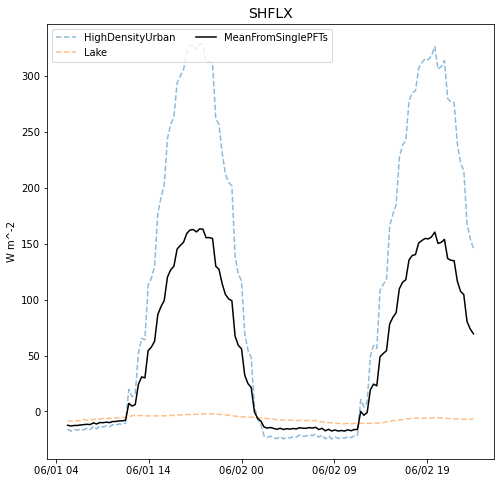

In [44]:
fig, axs0 = plt.subplots(1,1, figsize=(8, 8))

for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs0.plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.SHFLX.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs0.plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.SHFLX.values),'k',label='MeanFromSinglePFTs')
axs0.legend(ncol=2,loc='upper left')
axs0.set_title('SHFLX',fontsize=14)
axs0.set_ylabel('W m^-2')
# axs[0].set_ylim([-50,275])
axs0.xaxis.set_major_formatter(myFmt)
axs0.xaxis.set_major_locator(plt.MaxNLocator(5))



Text(0.5, 0, 'Time (UTC: mm/dd hh)')

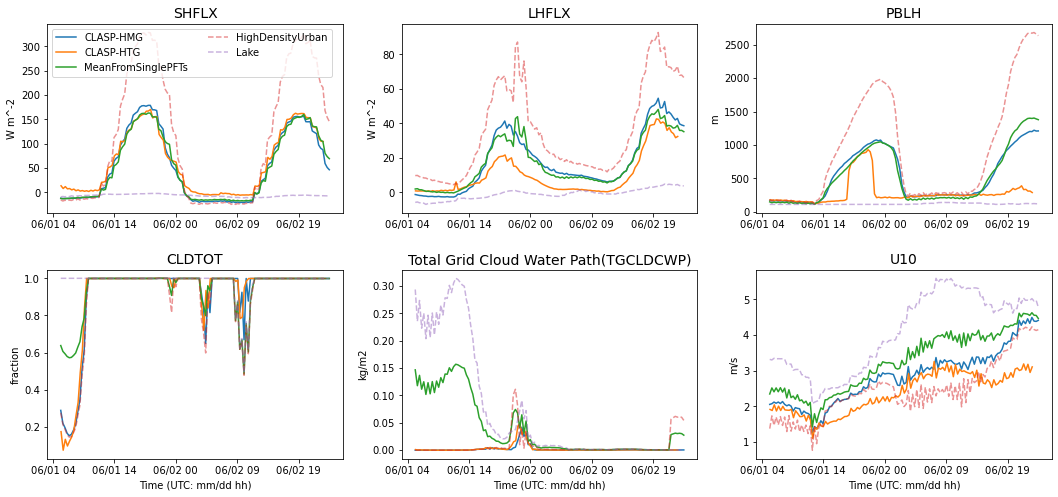

In [30]:
# Format for time on x-axis
myFmt = mdates.DateFormatter('%m/%d %H')

fig, axs = plt.subplots(2,3, figsize=(18, 8))
axs      = axs.ravel()
fig.subplots_adjust(hspace=0.3)

axs[0].plot(times, np.squeeze(camDS_5050hmg.SHFLX.values),label='CLASP-HMG')
axs[0].plot(timesHTG, np.squeeze(camDS_5050htg.SHFLX.values),label='CLASP-HTG')
axs[0].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.SHFLX.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[0].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.SHFLX.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[0].legend(ncol=2,loc='upper left')
axs[0].set_title('SHFLX',fontsize=14)
axs[0].set_ylabel('W m^-2')
# axs[0].set_ylim([-50,275])
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[1].plot(times, np.squeeze(camDS_5050hmg.LHFLX.values),label='CLASP-HMG')
axs[1].plot(timesHTG, np.squeeze(camDS_5050htg.LHFLX.values),label='CLASP-HTG')
axs[1].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.LHFLX.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[1].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.LHFLX.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[1].set_title('LHFLX',fontsize=14)
axs[1].set_ylabel('W m^-2')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[2].plot(times, np.squeeze(camDS_5050hmg.PBLH.values),label='CLASP-HMG')
axs[2].plot(timesHTG, np.squeeze(camDS_5050htg.PBLH.values),label='CLASP-HTG')
axs[2].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.PBLH.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[2].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.PBLH.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[2].set_title('PBLH',fontsize=14)
axs[2].set_ylabel('m')
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[3].plot(times, np.squeeze(camDS_5050hmg.CLDTOT.values),label='CLASP-HMG')
axs[3].plot(timesHTG, np.squeeze(camDS_5050htg.CLDTOT.values),label='CLASP-HTG')
axs[3].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.CLDTOT.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[3].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.CLDTOT.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[3].set_title('CLDTOT',fontsize=14)
axs[3].set_ylabel('fraction')
axs[3].xaxis.set_major_formatter(myFmt)
axs[3].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[3].set_xlabel('Time (UTC: mm/dd hh)')
#axs[3].set_ylim([0.5,1.1])

axs[4].plot(times, np.squeeze(camDS_5050hmg.TGCLDCWP.values),label='CLASP-HMG')
axs[4].plot(timesHTG, np.squeeze(camDS_5050htg.TGCLDCWP.values),label='CLASP-HTG')
axs[4].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.TGCLDCWP.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[4].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.TGCLDCWP.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[4].set_title('Total Grid Cloud Water Path(TGCLDCWP)',fontsize=14)
axs[4].set_ylabel('kg/m2')
axs[4].xaxis.set_major_formatter(myFmt)
axs[4].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[4].set_xlabel('Time (UTC: mm/dd hh)')

axs[5].plot(times, np.squeeze(camDS_5050hmg.U10.values),label='CLASP-HMG')
axs[5].plot(timesHTG, np.squeeze(camDS_5050htg.U10.values),label='CLASP-HTG')
axs[5].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.U10.values),label='MeanFromSinglePFTs')
for iSfc in range(len(camDS_indivdSfc5050_keepVars.sfcType.values)):
    axs[5].plot(times,np.squeeze(camDS_indivdSfc5050_keepVars.U10.values[iSfc,:,:,:]),'--',alpha=0.5,label=camDS_indivdSfc5050_keepVars.sfcType.values[iSfc])
axs[5].set_title('U10',fontsize=14)
axs[5].set_ylabel('m/s')
axs[5].xaxis.set_major_formatter(myFmt)
axs[5].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[5].set_xlabel('Time (UTC: mm/dd hh)')




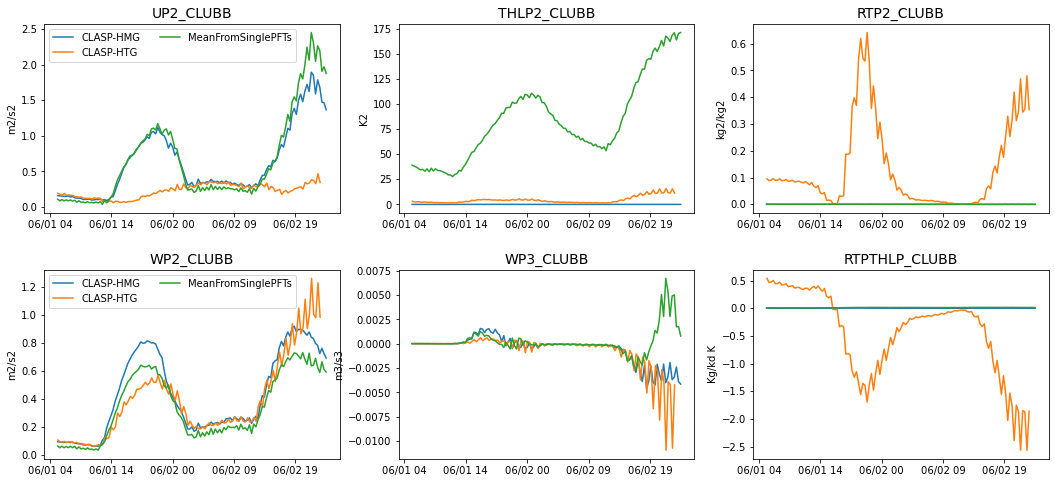

In [34]:
# Format for time on x-axis
myFmt = mdates.DateFormatter('%m/%d %H')

fig, axs = plt.subplots(2,3, figsize=(18, 8))
axs      = axs.ravel()
fig.subplots_adjust(hspace=0.3)

axs[0].plot(times, np.squeeze(newDS_CLASP_5050hmg.UP2_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[0].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.UP2_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[0].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.UP2_CLUBB_interp.values)[:,-1],label='MeanFromSinglePFTs')
axs[0].legend(ncol=2,loc='upper left')
axs[0].set_title('UP2_CLUBB',fontsize=14)
axs[0].set_ylabel('m2/s2')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[1].plot(times, np.squeeze(newDS_CLASP_5050hmg.THLP2_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[1].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.THLP2_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[1].plot(times, np.squeeze(thlp2_sfc5050_withHTG)[:,-1],label='MeanFromSinglePFTs')
axs[1].set_title('THLP2_CLUBB',fontsize=14)
axs[1].set_ylabel('K2')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[2].plot(times, np.squeeze(newDS_CLASP_5050hmg.RTP2_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[2].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.RTP2_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[2].plot(times, np.squeeze(rtp2_sfc5050_withHTG)[:,-1],label='MeanFromSinglePFTs')
axs[2].set_title('RTP2_CLUBB',fontsize=14)
axs[2].set_ylabel('kg2/kg2')
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[3].plot(times, np.squeeze(newDS_CLASP_5050hmg.WP2_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[3].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.WP2_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[3].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.WP2_CLUBB_interp.values)[:,-1],label='MeanFromSinglePFTs')
axs[3].legend(ncol=2,loc='upper left')
axs[3].set_title('WP2_CLUBB',fontsize=14)
axs[3].set_ylabel('m2/s2')
axs[3].xaxis.set_major_formatter(myFmt)
axs[3].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[4].plot(times, np.squeeze(newDS_CLASP_5050hmg.WP3_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[4].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.WP3_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[4].plot(times, np.squeeze(newDS_indivdSfc5050_fullWgt.WP3_CLUBB_interp.values)[:,-1],label='MeanFromSinglePFTs')
axs[4].set_title('WP3_CLUBB',fontsize=14)
axs[4].set_ylabel('m3/s3')
axs[4].xaxis.set_major_formatter(myFmt)
axs[4].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[5].plot(times, np.squeeze(newDS_CLASP_5050hmg.RTPTHLP_CLUBB_interp.values)[:,-1],label='CLASP-HMG')
axs[5].plot(timesHTG, np.squeeze(newDS_CLASP_5050htg.RTPTHLP_CLUBB_interp.values)[:,-1],label='CLASP-HTG')
axs[5].plot(times, np.squeeze(thlpRtp_sfc5050_withHTG)[:,-1],label='MeanFromSinglePFTs')
axs[5].set_title('RTPTHLP_CLUBB',fontsize=14)
axs[5].set_ylabel('Kg/kd K')
axs[5].xaxis.set_major_formatter(myFmt)
axs[5].xaxis.set_major_locator(plt.MaxNLocator(5))
